In [110]:
import pandas as pd
import numpy as np
import os
import warnings
import sys

from tqdm import tqdm
import zlib

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
from matplotlib.ticker import PercentFormatter

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(42)
np.set_printoptions(threshold=sys.maxsize)

In [111]:
###########################################################################################################
## Plotting Palette
###########################################################################################################

# Create a dict object containing U.C. Berkeley official school colors for plot palette 
# reference : https://alumni.berkeley.edu/brand/color-palette

berkeley_palette = {'berkeley_blue'     : '#003262',
                    'california_gold'   : '#FDB515',
                    'metallic_gold'     : '#BC9B6A',
                    'founders_rock'     : '#2D637F',
                    'medalist'          : '#E09E19',
                    'bay_fog'           : '#C2B9A7',
                    'lawrence'          : '#00B0DA',
                    'sather_gate'       : '#B9D3B6',
                    'pacific'           : '#53626F',
                    'soybean'           : '#9DAD33',
                    'california_purple' : '#5C3160',
                    'south_hall'        : '#6C3302'}


In [112]:
df, data_path = {}, 'data/'
for f, l, n, t in zip(['IdLookupTable.csv', 'SampleSubmission.csv', 'test.csv', 'training.csv'],
                        ['id_lookup', 'sample_submission', 'test', 'train'],
                        [['row_id', 'image_id', 'feature_name', 'location'],
                            ['row_id', 'location'],
                            ['image_id', 'image'],
                            ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 
                            'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 
                            'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 
                            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 
                            'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 
                            'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'image']],
                            [{'row_id':'uint16', 'image_id':'uint16', 'location':'float32'},
                            {'row_id':'uint16', 'location':'float32'},
                            {'image_id':'uint16', 'image':'object'},
                            {'left_eye_center_x':'float32', 'left_eye_center_y':'float32', 'right_eye_center_x':'float32', 'right_eye_center_y':'float32', 
                            'left_eye_inner_corner_x':'float32', 'left_eye_inner_corner_y':'float32', 'left_eye_outer_corner_x':'float32', 'left_eye_outer_corner_y':'float32', 
                            'right_eye_inner_corner_x':'float32', 'right_eye_inner_corner_y':'float32', 'right_eye_outer_corner_x':'float32', 'right_eye_outer_corner_y':'float32', 
                            'left_eyebrow_inner_end_x':'float32', 'left_eyebrow_inner_end_y':'float32', 'left_eyebrow_outer_end_x':'float32', 'left_eyebrow_outer_end_y':'float32', 
                            'right_eyebrow_inner_end_x':'float32', 'right_eyebrow_inner_end_y':'float32', 'right_eyebrow_outer_end_x':'float32', 'right_eyebrow_outer_end_y':'float32', 
                            'nose_tip_x':'float32', 'nose_tip_y':'float32', 'mouth_left_corner_x':'float32', 'mouth_left_corner_y':'float32', 'mouth_right_corner_x':'float32', 
                            'mouth_right_corner_y':'float32', 'mouth_center_top_lip_x':'float32', 'mouth_center_top_lip_y':'float32', 'mouth_center_bottom_lip_x':'float32', 
                            'mouth_center_bottom_lip_y':'float32', 'image':'object'}]):
    print("Loading file '%s'..." % "".join( (data_path, f)))
    df[l] = pd.read_csv("".join( (data_path, f) ), names = n, dtype = t, skiprows = 1)
    if "image" in df[l]:
        print("\tProcessing %d images..." % df[l].shape[0])
        df[l]['image'] = df[l]["image"].map(lambda x: np.array(list(map(int, x.split(" ")))))
    print("\tDone!  shape:", df[l].shape, "\n")

print("All data loaded in to dataframe 'df'.")


Loading file 'data/IdLookupTable.csv'...
	Done!  shape: (27124, 4) 

Loading file 'data/SampleSubmission.csv'...
	Done!  shape: (27124, 2) 

Loading file 'data/test.csv'...
	Processing 1783 images...
	Done!  shape: (1783, 2) 

Loading file 'data/training.csv'...
	Processing 7049 images...
	Done!  shape: (7049, 31) 

All data loaded in to dataframe 'df'.


In [113]:
print(type(df.get('train')))
print(df.get('train').columns)

<class 'pandas.core.frame.DataFrame'>
Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'image'],
      dtype='object')


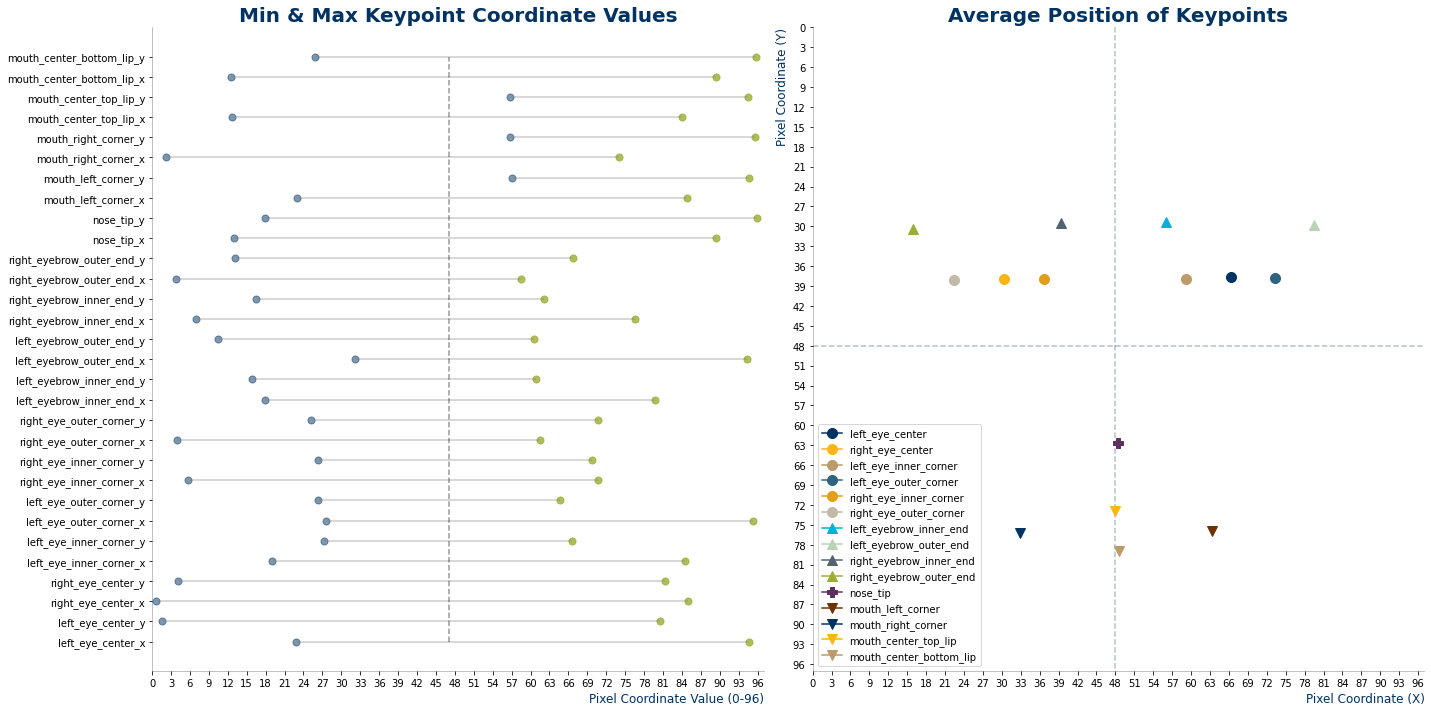

In [114]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)

train = df['train'].copy()
df_rng = {}
for c in [c for c in train.columns if c.endswith('_x') | c.endswith('_y')]:
    df_rng[c] = {'min':np.nanmin(train[c].values), 'max':np.nanmax(train[c].values),
        'avg':np.nanmean(train[c].values)}
df_rng = pd.DataFrame(df_rng).T

y_idx = range(1, df_rng.shape[0] + 1)
ax.hlines(y = y_idx, xmin = df_rng['min'], xmax = df_rng['max'], color = 'grey', alpha = 0.4)
ax.scatter(df_rng['min'], y_idx, color = berkeley_palette['berkeley_blue'], alpha = 0.5, label = 'min', s = 50)
ax.scatter(df_rng['max'], y_idx, color = berkeley_palette['soybean'], alpha = 0.8, label = 'max', s = 50)
plt.yticks(y_idx, df_rng.index.values)
ax.set_title('Min & Max Keypoint Coordinate Values', color = berkeley_palette['berkeley_blue'], 
    fontsize = 20, fontweight = 'bold')
ax.spines["top"].set_alpha(.0)
ax.spines["bottom"].set_alpha(.3)
ax.spines["right"].set_alpha(.0)
ax.spines["left"].set_alpha(.3)
ax.set_xlim(0,97)
ax.set_xticks(range(0,97,3))
ax.set_xlabel("Pixel Coordinate Value (0-96)", fontsize = 12, horizontalalignment='right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.vlines(x=47, ymin=min(y_idx), ymax=max(y_idx), color = "#000000", linestyle = "dashed", alpha = 0.4)

ax = fig.add_subplot(122)

cols = df_rng[['avg']].T.columns
df_rng = df_rng[['avg']].T.values[0]
col_idx = 0
for c in range(0, len(df_rng), 2):
    if 'eye_' in cols[c]: mkr = "o"
    elif 'eyebrow' in cols[c]: mkr = "^"
    elif 'nose' in cols[c]: mkr = "P"
    else: mkr = "v"
    ax.plot(df_rng[c], df_rng[c+1], marker = mkr, markersize = 10, label = cols[c][:-2],
        color = berkeley_palette[list(berkeley_palette.keys())[col_idx]])
    col_idx += 1
    if col_idx >= len(list(berkeley_palette.keys())): col_idx = 0

ax.set_xlim(0,97)
ax.set_xticks(range(0,97,3))
ax.set_ylim(0,97)
ax.set_yticks(range(0,97,3))

ax.vlines(x = 48, ymin = 0, ymax = 97, linestyle = 'dashed', 
    color = berkeley_palette['berkeley_blue'], alpha = 0.3)

ax.hlines(y = 48, xmin = 0, xmax = 97, linestyle = 'dashed', 
    color = berkeley_palette['berkeley_blue'], alpha = 0.3)

ax.invert_yaxis()
ax.set_title('Average Position of Keypoints', color = berkeley_palette['berkeley_blue'], 
    fontsize = 20, fontweight = 'bold')
ax.spines["top"].set_alpha(.0)
ax.spines["bottom"].set_alpha(.3)
ax.spines["right"].set_alpha(.0)
ax.spines["left"].set_alpha(.3)
ax.set_xlabel("Pixel Coordinate (X)", fontsize = 12, horizontalalignment='right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Pixel Coordinate (Y)", fontsize = 12, horizontalalignment='right', y = 1.0, color = berkeley_palette['berkeley_blue'])
ax.legend()

plt.tight_layout()
plt.show()


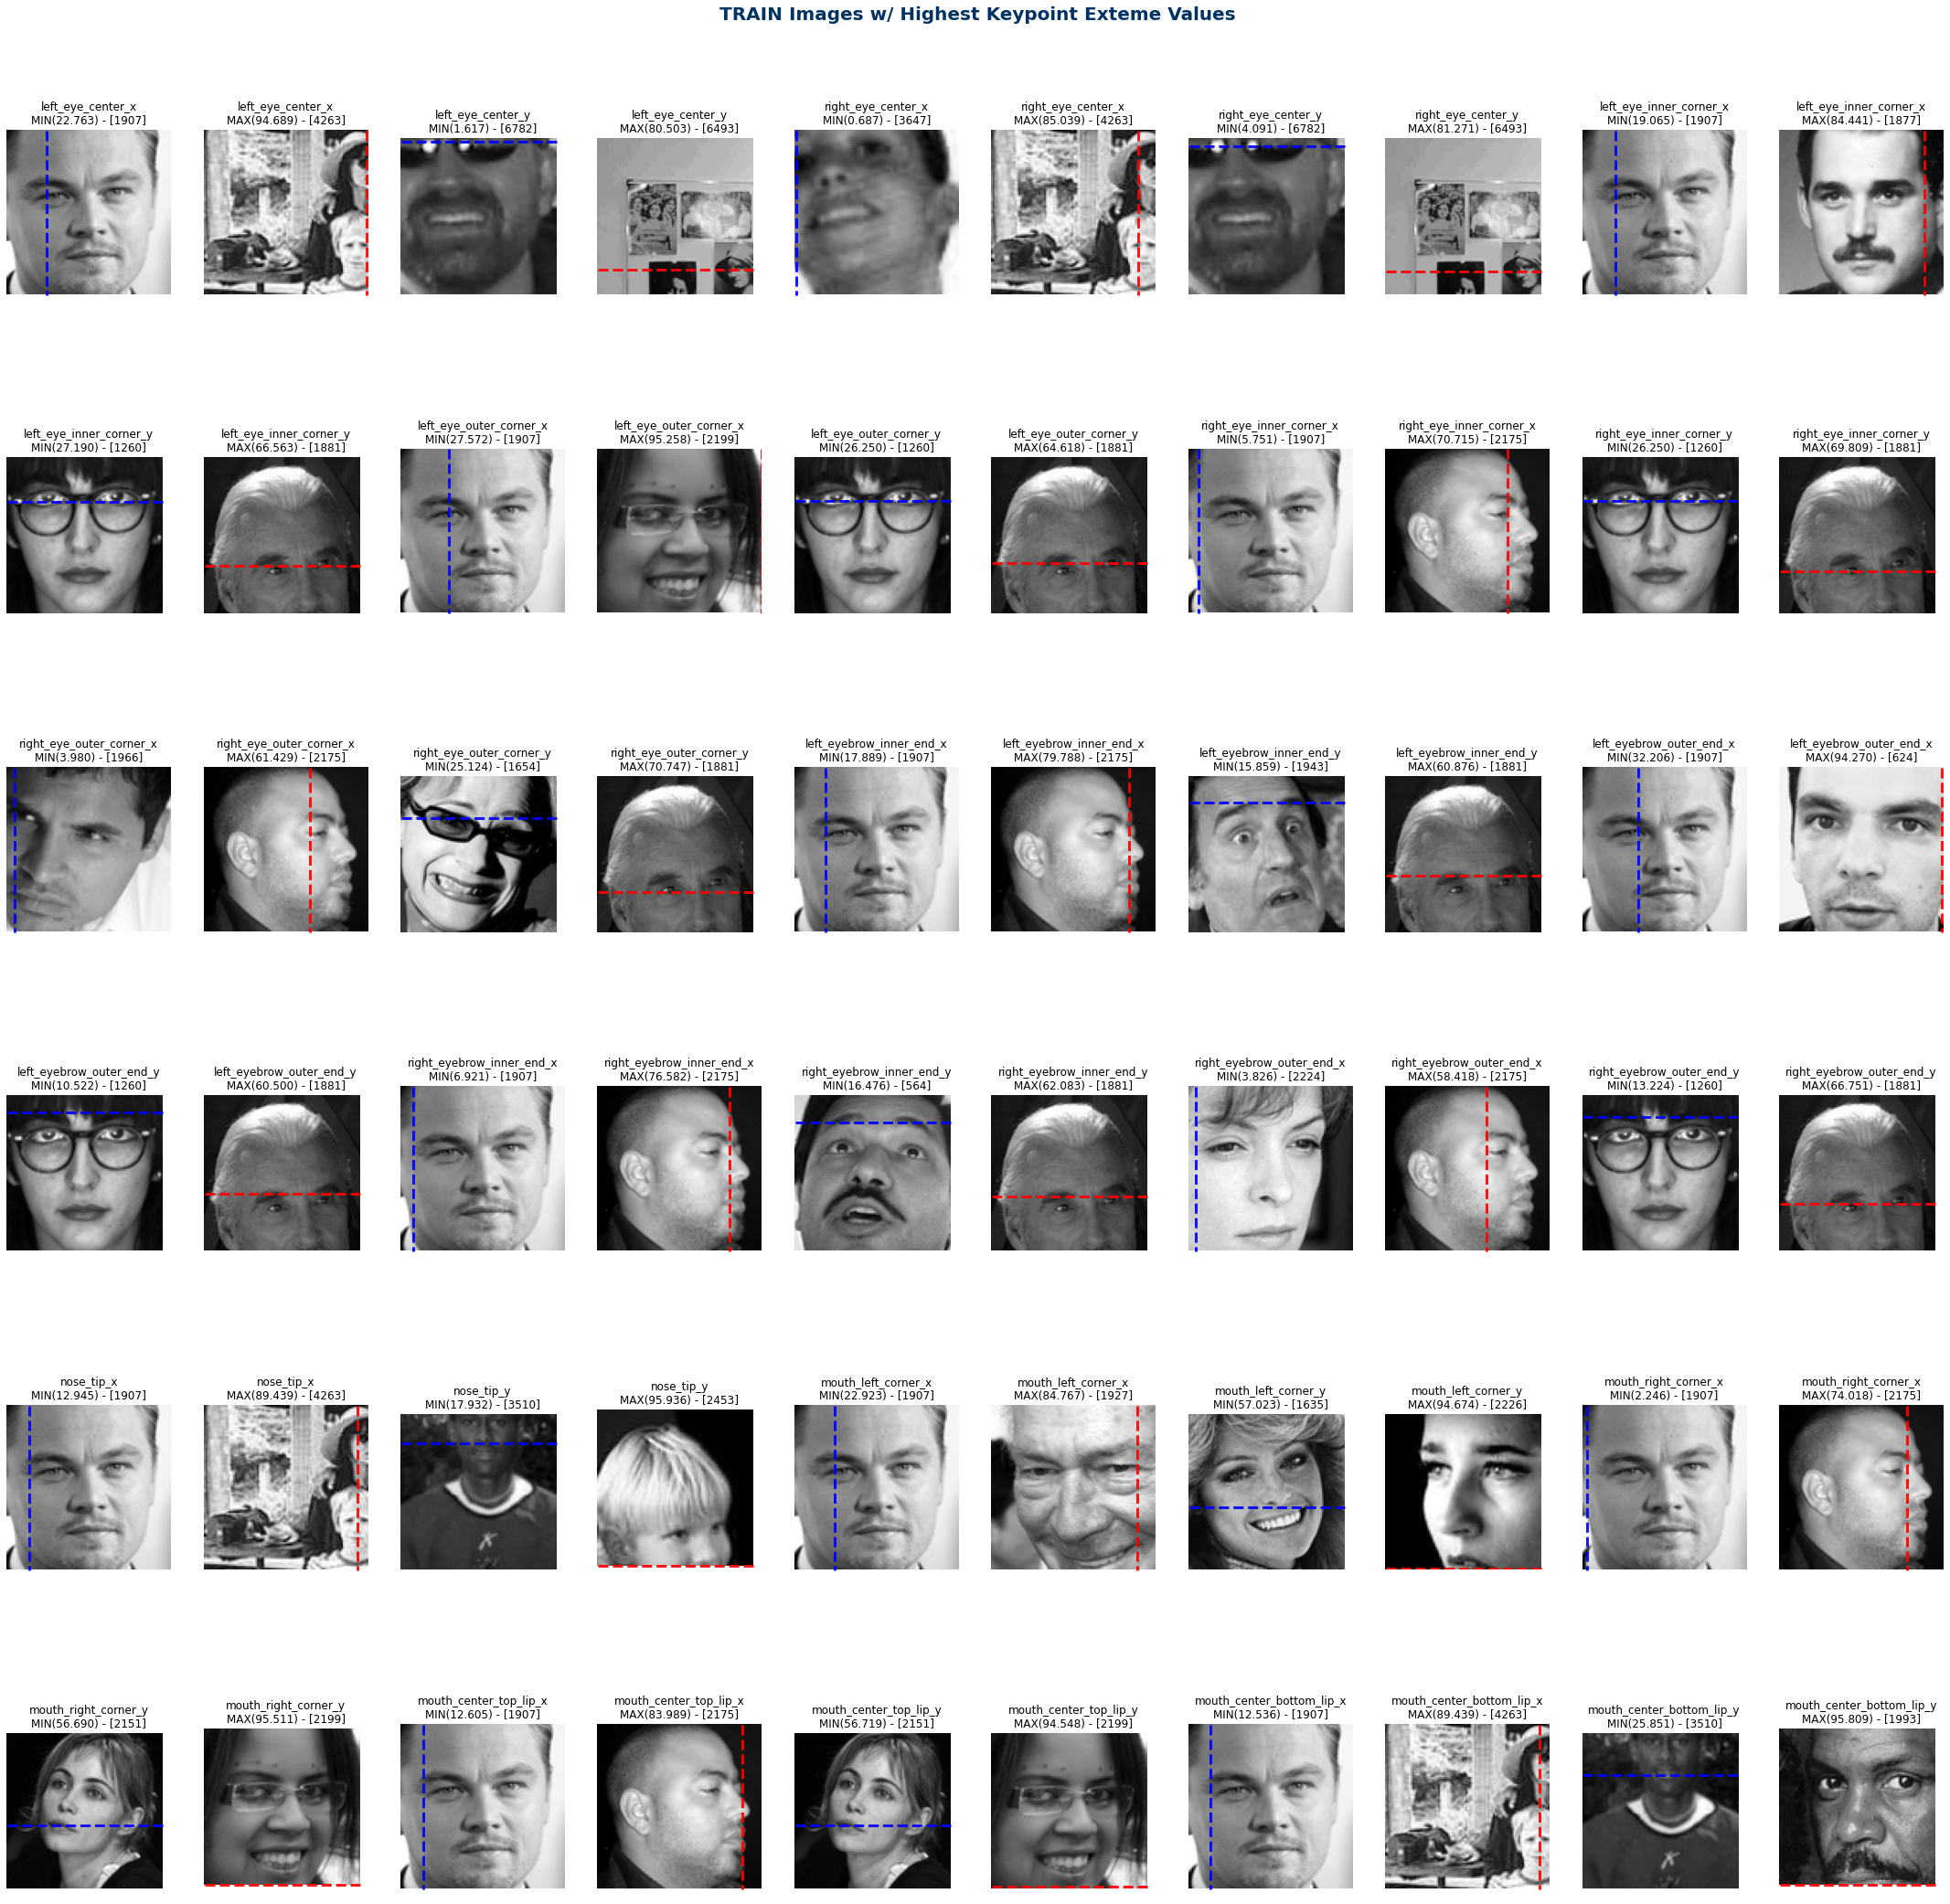

In [115]:
train = df['train'].copy()
final_train = df['train'].copy()
idx_vals = train.index.values
df_rng = {}
for c in [c for c in train.columns if c.endswith('_x') | c.endswith('_y')]:
    df_rng[c] = {'min':np.nanmin(train[c].values), 'max':np.nanmax(train[c].values),
        'avg':np.nanmean(train[c].values)}
df_rng = pd.DataFrame(df_rng).T

cols = ['min_value', 'max_value', 'min_img', 'max_img', 'min_idx', 'max_idx']
extremes = {}
for i in df_rng.index.values:
    min_val, max_val = df_rng.loc[i]['min'], df_rng.loc[i]['max']
    min_img = train[(train[i] == min_val)].image.values[0]
    max_img = train[(train[i] == max_val)].image.values[0]
    min_idx = train[(train[i] == min_val)].index.values
    max_idx = train[(train[i] == max_val)].index.values
    extremes[i] = [min_val, max_val, min_img, max_img, min_idx, max_idx]

df_extremes = pd.DataFrame(extremes).T
df_extremes.columns = cols

fig = plt.figure(figsize=(30, 30))
fig.suptitle('TRAIN Images w/ Highest Keypoint Exteme Values', size = 20, color = berkeley_palette['berkeley_blue'], y = 1.01, weight = 'bold')
idx = 0
for i, r in df_extremes.iterrows():
    idx += 1
    ax = fig.add_subplot(6,10,idx)
    ax.imshow(r.min_img.reshape(96,96), cmap = 'gray')
    ax.set_title("".join([i,"\n","MIN(" + "%.3f" % r.min_value + ") - [%d]" % r.min_idx ]))
    plt.axis("off")
    if i.endswith('_x'):
        ax.vlines(x = r.min_value, ymin = 0, ymax = 96, linestyle = 'dashed', color = 'blue', alpha = 0.9, linewidth = 3)
    else:
        ax.hlines(y = r.min_value, xmin = 0, xmax = 96, linestyle = 'dashed', color = 'blue', alpha = 0.9, linewidth = 3)

    idx += 1
    ax = fig.add_subplot(6,10,idx)
    ax.imshow(r.max_img.reshape(96,96), cmap = 'gray')
    ax.set_title("".join([i,"\n","MAX(" + "%.3f" % r.max_value + ") - [%d]" % r.max_idx]))
    plt.axis("off")
    if i.endswith('_x'):
        ax.vlines(x = r.max_value, ymin = 0, ymax = 96, linestyle = 'dashed', color = 'red', alpha = 0.9, linewidth = 3)
    else:
        ax.hlines(y = r.max_value, xmin = 0, xmax = 96, linestyle = 'dashed', color = 'red', alpha = 0.9, linewidth = 3)

plt.tight_layout()
plt.show()

In [117]:
# add 1st flag for preprocessing : isBadImage
extremeIndex = []
for keypoint in extremes.keys():
    minIndex = extremes[keypoint][4]
    maxIndex = extremes[keypoint][5]
    if minIndex not in extremeIndex:
        extremeIndex.append(minIndex[0])
    if maxIndex not in extremeIndex:
        extremeIndex.append(maxIndex[0])
extremeArray = np.zeros(7049)
for i in extremeIndex:
    extremeArray[i] = 1
final_train['is_extreme_image'] = extremeArray

In [118]:
# add 2nd flag for preprocessing : isMissingPixel 
isMissingPixel = np.zeros(7049)
final_train['is_missing_pixel'] = isMissingPixel

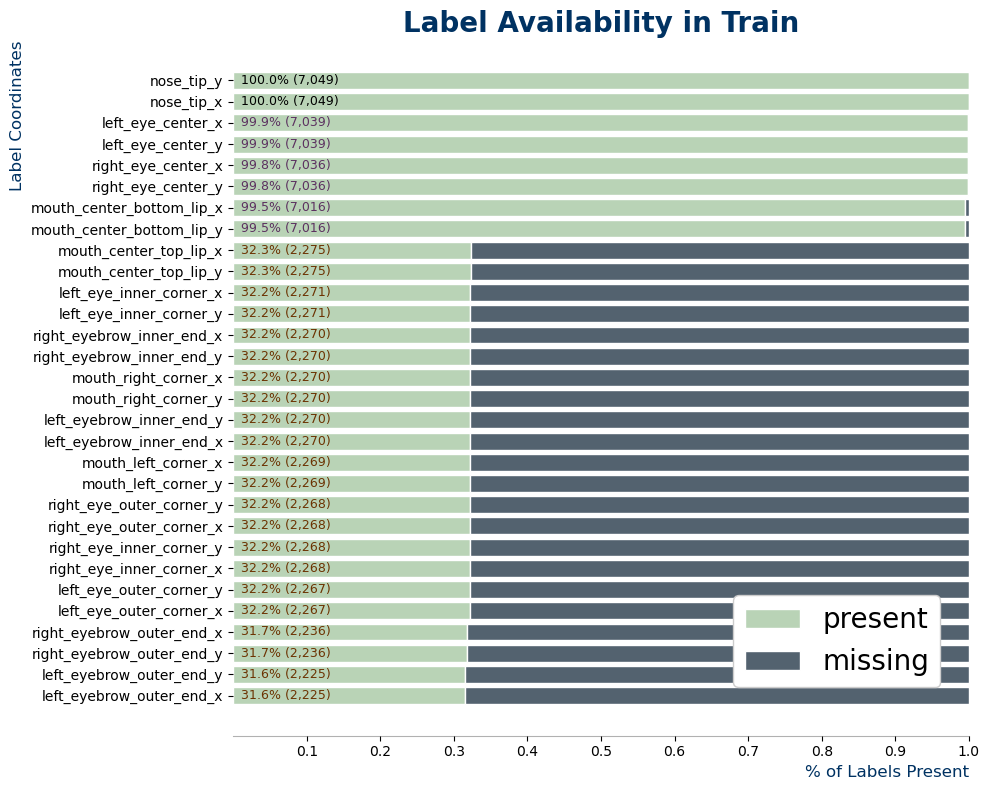

In [120]:
# add 3rdflag for preprocessing : missing keypoints
# Missing data analysis
cols = [c for c in df['train'].columns if 'image' not in c]
missing = pd.DataFrame(df['train'][cols].isnull().sum().sort_values(ascending = False)).reset_index()
missing.columns = ['keypoint', 'num_missing']
missing['pct_missing'] = (missing.num_missing / df['train'].shape[0]).astype(np.float32)
missing['pct_present'] = 1 - missing.pct_missing

f = plt.figure(figsize=(10, 8), dpi = 100)
ax = f.add_subplot(111)

ax.barh(missing.keypoint, missing.pct_present, color = berkeley_palette['sather_gate'], edgecolor = 'white', label = 'present')
ax.barh(missing.keypoint, missing.pct_missing, left = missing.pct_present, color = berkeley_palette['pacific'], edgecolor = 'white', label = 'missing')
ax.set_title('Label Availability in Train', color = berkeley_palette['berkeley_blue'], 
    fontsize = 20, fontweight = 'bold')
ax.spines["top"].set_alpha(.0)
ax.spines["bottom"].set_alpha(.3)
ax.spines["right"].set_alpha(.0)
ax.spines["left"].set_alpha(.0)
ax.set_xlabel("% of Labels Present", fontsize = 12, horizontalalignment='right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Label Coordinates", fontsize = 12, horizontalalignment='right', y = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_xticks(np.arange(0.1, 1.1, 0.1))

for s, l, q in zip([j for j in missing.pct_present], missing.keypoint, [df['train'].shape[0] - j for j in missing.num_missing]):
    if s == 1: col = "#000000"
    elif 0.9 <= s < 1: col = berkeley_palette['california_purple']
    else: col = berkeley_palette['south_hall']
    plt.text(0.01, l, " ".join( ('%.1f%%' % (s * 100), "(" + format(q, ",d") + ")") ), verticalalignment='center', horizontalalignment = 'left', fontsize = 9, color = col)

plt.legend(loc = 'lower right', bbox_to_anchor = (0.48, 0.05, 0.5, 0.5), framealpha = 1.0, fontsize = 20)
plt.tight_layout()
plt.show()

cols = [c for c in df['train'].columns if c.endswith('_x') | c.endswith('_y')]
train = df['train'].copy()[cols]
train = train.isnull().sum(axis=1).reset_index()
final_train['num_missing_keypoints'] = train[0]


In [121]:
final_train.to_csv('processed_training_with_duplicate.csv')

In [122]:
# add 4th flag for preprocesssing : has_duplicate (averaged keypoint values)
# Evaluate the presence of duplicate TRAIN images

train = df['train'].reset_index().copy()
train['hash_image'] = train.image.map(lambda x: zlib.adler32(x))
train_dupes_hash = pd.DataFrame(train.groupby(by='hash_image').index.count().sort_values()).reset_index()
train_dupes_hash.columns = ['hash_image', 'frequency']
train_dupes_hash = train_dupes_hash[(train_dupes_hash.frequency > 1)]
train_dupes_hash = pd.merge(train_dupes_hash, train[['index', 'hash_image']],  how = 'left', on=['hash_image']).sort_values(by=['frequency', 'hash_image'], ascending = False)
train.drop(columns=['hash_image'], inplace=True)
print("TRAIN has %d duplicate rows (%d unique images)" % (len(train_dupes_hash), len(np.unique(train_dupes_hash.hash_image))))


TRAIN has 1098 duplicate rows (543 unique images)


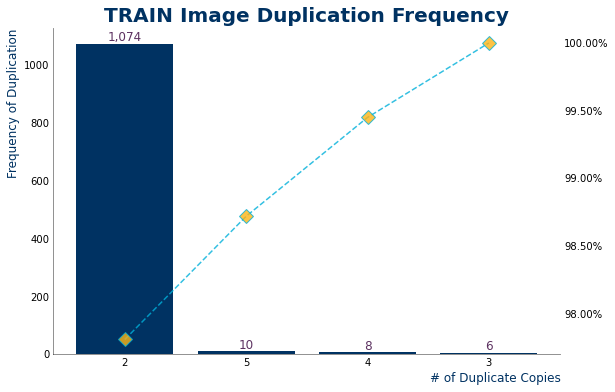

In [123]:
df_train_dupes = pd.DataFrame(train_dupes_hash.groupby(by='frequency').index.count()).sort_values(by='index', ascending = False)
df_train_dupes.columns = ['duplicates']
df_train_dupes['cuml_pct'] = round(df_train_dupes.cumsum()/df_train_dupes.duplicates.sum() * 100,2)

fig = plt.figure(figsize=(20,6))

# TRAIN
ax = fig.add_subplot(121)
ax.bar(df_train_dupes.index.astype(str), df_train_dupes.duplicates, color = berkeley_palette['berkeley_blue'])
ax.spines["top"].set_alpha(.0)
ax.spines["bottom"].set_alpha(.3)
ax.spines["right"].set_alpha(.0)
ax.spines["left"].set_alpha(.3)
ax2 = ax.twinx()
ax2.plot(df_train_dupes.index.astype(str), df_train_dupes.cuml_pct, color = berkeley_palette['lawrence'], marker = "D", 
    ms = 10, markerfacecolor = berkeley_palette['california_gold'], linestyle = "dashed", alpha = 0.8)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.set_title('TRAIN Image Duplication Frequency', color = berkeley_palette['berkeley_blue'], 
    fontsize = 20, fontweight = 'bold')
ax2.spines["top"].set_alpha(.0)
ax2.spines["bottom"].set_alpha(.3)
ax2.spines["right"].set_alpha(.0)
ax2.spines["left"].set_alpha(.3)
ax.set_xlabel("# of Duplicate Copies", fontsize = 12, horizontalalignment='right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Frequency of Duplication", fontsize = 12, horizontalalignment='right', y = 1.0, color = berkeley_palette['berkeley_blue'])
ax2.tick_params(axis = 'both', length = 0)
ax.tick_params(axis = 'both', length = 0)
for l, f in zip(df_train_dupes.index.astype(str), df_train_dupes.duplicates):
    ax.text(l, f + 20, format(f, ",d"), verticalalignment='center', horizontalalignment = 'center', fontsize = 12, color = berkeley_palette['california_purple'])
plt.show()


In [124]:
# Do the duplicated TRAIN images at least having matching labels?

first_duped_image_hash = train_dupes_hash.iloc[0, train_dupes_hash.columns.get_loc('hash_image')]
print(train_dupes_hash)
print(first_duped_image_hash)
train_dupes_idx = train_dupes_hash.loc[(train_dupes_hash.hash_image == first_duped_image_hash)]['index'].values
print(train_dupes_idx)
cols = [c for c in train.columns if c.endswith('_x') | c.endswith('_y')]

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

train.loc[(train['index'].isin(train_dupes_idx))][cols].style\
    .apply(highlight_max)\
    .set_na_rep("N/A").format(None, na_rep="N/A").highlight_null(berkeley_palette['south_hall'])

      hash_image  frequency  index
1093  2227719099          5   2490
1094  2227719099          5   3741
1095  2227719099          5   5414
1096  2227719099          5   5969
1097  2227719099          5   6583
...          ...        ...    ...
153     21965156          2   6547
164      7439125          2   4438
165      7439125          2   6101
170      5518700          2   2451
171      5518700          2   4266

[1098 rows x 3 columns]
2227719099
[2490 3741 5414 5969 6583]


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
2490,65.334175,35.471878,29.366461,37.767685,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,50.411373,64.934769,N/A,N/A,N/A,N/A,N/A,N/A,50.028778,74.883240
3741,65.446320,37.164719,29.093319,39.233547,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,51.555363,68.197731,N/A,N/A,N/A,N/A,N/A,N/A,50.964199,76.177589
5414,65.501717,36.826946,28.705406,37.491913,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,51.315178,67.194923,N/A,N/A,N/A,N/A,N/A,N/A,51.093525,79.608154
5969,65.636299,36.285984,28.892820,38.154251,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,52.869461,65.867554,N/A,N/A,N/A,N/A,N/A,N/A,51.312550,75.831932
6583,65.277435,37.893036,29.051128,37.893036,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,50.183113,68.356033,N/A,N/A,N/A,N/A,N/A,N/A,49.359776,81.293228


In [125]:
# It looks like the duplicated images in TRAIN don't reliably have the same truth label values (above)
# One option would be for us to merge these images together, and average the coordinates acorss all labels.
# Here's what that looks like:

pd.DataFrame(train.loc[(train['index'].isin(train_dupes_idx))][cols].dropna(axis='columns').mean()).T.style\
    .set_properties(**{'background-color':'black',
                        'color': 'lawngreen',
                        'border-color':'white'})

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,65.439186,36.728512,29.021826,38.108086,51.266899,66.910202,50.551765,77.558823


In [129]:
def check_dup(img, ref):
    if img not in ref:
        ref.append(img)
        return 0
    else:
        return 1
    
# de-dupe copied of TRAIN and TEST 
ref = []
train = final_train.reset_index().copy()
train['hash_image'] = train.image.map(lambda x: zlib.adler32(x))
train['is_duplicate'] = train.hash_image.map(lambda x: check_dup(x, ref))
train = train.drop(['index', 'hash_image'], axis=1)
np.set_printoptions(threshold=sys.maxsize)
train.to_csv('processed_training.csv')

ref = []
test = df['test'].reset_index().copy()
test['hash_image'] = test.image.map(lambda x: zlib.adler32(x))
test['is_duplicate'] = test.hash_image.map(lambda x: check_dup(x, ref))
test = test.drop(['index', 'hash_image'], axis=1)
np.set_printoptions(threshold=sys.maxsize)
test.to_csv('processed_test.csv')


In [130]:
# drop all cols except flags
train_flag = train[['is_extreme_image', 'is_missing_pixel', 'num_missing_keypoints', 'is_duplicate']].copy()
test_flag = test[['is_duplicate']].copy()
np.set_printoptions(threshold=sys.maxsize)
train_flag.to_csv('processed_training_flag.csv')
test_flag.to_csv('processed_test_flag.csv')

In [131]:
# de-dupe copied of TRAIN and TEST 
train = final_train.reset_index().copy()
train['hash_image'] = train.image.map(lambda x: zlib.adler32(x))
train_dupes_hash = pd.DataFrame(train.groupby(by='hash_image').index.count().sort_values()).reset_index()
train_dupes_hash.columns = ['hash_image', 'frequency']
train_dupes_hash = train_dupes_hash[(train_dupes_hash.frequency > 1)]
train_dupes_hash = pd.merge(train_dupes_hash, train[['index', 'hash_image']],  how = 'left', on=['hash_image']).sort_values(by=['frequency', 'hash_image'], ascending = False)
#train.drop(columns=['hash_image'], inplace=True)

cols = [c for c in train.columns if 'index' not in c]
fixed_images = train[(train.index == -1)][cols].copy()
cols = [c for c in train.columns if c.endswith('_x') | c.endswith('_y')]

for hash_id in train_dupes_hash.hash_image.unique():
    train_idx = train_dupes_hash[(train_dupes_hash.hash_image == hash_id)]['index'].values
    img = train[(train['index'].isin(train_idx))].image.values[0]
    fixed = pd.DataFrame(pd.DataFrame(train[(train['index'].isin(train_idx))], columns=cols).mean(axis = 0)).T
    fixed['image'] = [img]
    fixed_images = fixed_images.append(fixed, ignore_index = True)

print("Train shape before truncate: %s" % str(train.shape))
train = train[~(train['index'].isin(train_dupes_hash['index'].values))]
print("Train shape after truncate: %s" % str(train.shape))

train = train.append(fixed_images, ignore_index = True).reset_index()
train.drop(columns=['index'], inplace = True)
print("Train shape after append: %s" % str(train.shape))

train = train.drop(['level_0', 'hash_image'], axis=1)
train.to_csv('processed_training_without_duplicate.csv')


Train shape before truncate: (7049, 36)
Train shape after truncate: (5951, 36)
Train shape after append: (6494, 36)


In [132]:
test = df['test'].reset_index().copy()
test['hash_image'] = test.image.map(lambda x: zlib.adler32(x))

new_test = test[(test.index == -1)]

print("Test shape before truncate: %s" % str(test.shape))
for idx, hash_id in zip(test['index'], test.hash_image):
    if not (hash_id in list(new_test.hash_image.values)):
        new_test = new_test.append(test.loc[(test['index'] == idx)], ignore_index = True)

test = new_test
print("Test shape after truncate: %s" % str(test.shape))

test.to_csv('processed_test_without_duplicate.csv')

Test shape before truncate: (1783, 4)
Test shape after truncate: (1752, 4)
